In [2]:
import glob
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from pymutspec.annotation.spectra import get_cossim, complete_sbs192_columns, collapse_sbs192
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
import pymutspec

from Bio import SeqIO, AlignIO
from Bio.Data import CodonTable
from Bio.SeqRecord import SeqRecord
from Bio.Align.AlignInfo import SummaryInfo
from scipy import spatial
import ete3
from ete3 import PhyloTree

import warnings
warnings.filterwarnings("ignore")

In [3]:
coda = CodonAnnotation(gencode=2)

## Collect obs

In [272]:
outdir = '/home/kpotoh/nemu-pipeline/data/chordata2/output'
paths_msa = glob.glob(outdir + '/*/*/msa_nuc.fasta')
paths_tree = glob.glob(outdir + '/*/*/final_tree.nwk')
paths_state = glob.glob(outdir + '/*/*/work/*/*/iqtree_anc.state')

len(paths_msa), len(paths_tree), len(paths_state)

(9252, 9238, 18478)

In [291]:
# All ingroup nodes are called 'Node1'
for pt in paths_tree:
    t = PhyloTree(pt, format=1)
    for n in t.children:
        if n.name.startswith('Node'):
            if n.name != 'Node1':
                print(n.name)

In [200]:
def read_ingroup_msa(path):
    msa = AlignIO.read(path, 'fasta')
    for i,x in enumerate(msa):
        if x.name == 'OUTGRP':
            break
    assert msa[i].name == 'OUTGRP'
    del msa[i]
    return msa


def read_ingroup_msa_and_outgrp(path):
    msa = AlignIO.read(path, 'fasta')
    for i,x in enumerate(msa):
        if x.name == 'OUTGRP':
            break
    assert msa[i].name == 'OUTGRP'
    outgrp = str(msa[i].seq)
    del msa[i]
    return msa, outgrp


def collect_snp_from_consensus(rec: SeqRecord, consensus: str):
    muts = coda.extract_mutations_simple(consensus, str(rec.seq))
    return muts

### Test

In [155]:
msa, o = read_ingroup_msa_and_outgrp(paths_msa[10])
si = SummaryInfo(msa)
consensus = str(si.dumb_consensus())

In [6]:
data = []
for i, rec in enumerate(msa):
    m = collect_snp_from_consensus(rec, consensus)
    if len(m):
        data.append(m.assign(seq_id=i))

In [7]:
df = pd.concat(data)
df.head()

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,seq_id
0,T[A>G]C,1,258,3,ATA,ATG,M,M,0
1,C[T>C]G,2,549,3,CCT,CCC,P,P,0
0,C[A>G]A,2,309,3,TCA,TCG,S,S,1
0,C[A>G]C,2,606,3,GCA,GCG,A,A,2
1,G[A>G]T,2,648,3,GGA,GGG,G,G,2


In [8]:
df.groupby(['PosInGene', 'Mut']).Label.count().sort_index()

PosInGene  Mut    
54         C[A>C]C    7
78         T[A>G]A    5
81         C[A>G]C    1
84         T[G>A]C    3
90         A[A>G]C    2
                     ..
900        T[C>G]C    2
903        C[T>C]A    1
940        A[G>A]C    1
941        G[C>T]G    1
942        C[G>A]A    1
Name: Label, Length: 168, dtype: int64

<AxesSubplot:>

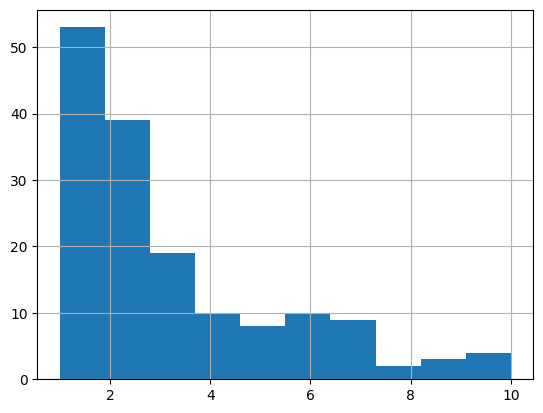

In [9]:
df.seq_id.value_counts().hist()

### Collect obs muts

In [56]:
def milti_collect(x, consensus):
    i, rec = x
    m = collect_snp_from_consensus(rec, consensus)
    if len(m):
        m = m.assign(seq_id=i)
    return m

p = Pool(64)

In [62]:
_ = p.map(partial(milti_collect, consensus=consensus), enumerate(msa))
x = pd.concat(_, ignore_index=True)

In [67]:
data = []
nseqs = []

j = 0
for path_fasta in tqdm.tqdm(paths_msa):
    j += 1
    p_elements = path_fasta.split('/')
    gene_species = p_elements[8]

    msa = read_ingroup_msa(path_fasta)
    nseqs.append([gene_species, len(msa)])
    si = SummaryInfo(msa)
    consensus = si.dumb_consensus(0.5, 'N')
    
    muts_from_seqs_lst = p.map(partial(milti_collect, consensus=consensus), enumerate(msa))
    muts_from_seqs_lst = [x for x in muts_from_seqs_lst if len(x)]
    # muts_from_seqs_lst = []
    # for i, rec in enumerate(msa):
    #     m = collect_snp_from_consensus(rec, consensus)
    #     if len(m):
    #         muts_from_seqs_lst.append(m.assign(seq_id=i))

    if len(muts_from_seqs_lst):
        mut = pd.concat(muts_from_seqs_lst, ignore_index=True).assign(gene_species=gene_species)
        data.append(mut)
    
    # if j > 10:
    #     break

obs_poly = pd.concat(data, ignore_index=True)
obs_poly.to_csv('../data/chordata2/obs_muts_poly.csv', index=False)

pd.DataFrame(nseqs, columns=['gene_species', 'nseqs']).to_csv('../data/chordata2/nseqs.csv', index=False)

100%|██████████| 9252/9252 [21:59<00:00,  7.01it/s]  


In [69]:
obs_poly

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,seq_id,gene_species
0,C[A>G]T,0,25,1,ATT,GTT,I,V,0,ND1__Eleotris_fusca
1,C[G>A]G,2,645,3,TCG,TCA,S,S,0,ND1__Eleotris_fusca
2,T[A>G]C,1,876,3,ATA,ATG,M,M,0,ND1__Eleotris_fusca
3,T[T>C]C,2,57,3,GTT,GTC,V,V,1,ND1__Eleotris_fusca
4,C[C>T]G,2,564,3,GCC,GCT,A,A,1,ND1__Eleotris_fusca
...,...,...,...,...,...,...,...,...,...,...
3782440,A[C>T]G,1,192,3,CAC,CAT,H,H,6,ND4L__Branchiostoma_belcheri
3782441,C[A>G]C,2,12,3,ACA,ACG,T,T,7,ND4L__Branchiostoma_belcheri
3782442,G[T>C]T,2,93,3,GGT,GGC,G,G,8,ND4L__Branchiostoma_belcheri
3782443,A[A>G]A,1,9,3,CAA,CAG,Q,Q,9,ND4L__Branchiostoma_belcheri


## Filter out ambigous positions and derive spectra

### Collect bad sites

In [96]:
# need to filter out amb msa columns (sites), i.e. drop mutations from these sites

thr0 = 0.50
thr1 = 0.05
thr2 = 0.05

j = 0
bad_sites = []
for path_fasta in tqdm.tqdm(paths_msa[2:]):
    j += 1
    p_elements = path_fasta.split('/')
    gene_species = p_elements[8]

    msa = read_ingroup_msa(path_fasta)
    si = SummaryInfo(msa)
    pssm = si.pos_specific_score_matrix().pssm
    
    nseqs = len(msa)
    ncols = msa.get_alignment_length()

    i = 0
    for site, (nuc, counts) in enumerate(pssm):
        counts_sorted = sorted(counts.values(), reverse=True)
        freqs_sorted = [x / sum(counts_sorted) for x in counts_sorted]
        if freqs_sorted[0] < thr0 or freqs_sorted[1] >= thr1 or freqs_sorted[2] >= thr2:
            # print(counts)
            i += 1
            bad_sites.append([gene_species, site, [round(x,2) for x in freqs_sorted]])

    # print(f'{gene_species} - amb cols: {i}, {i/ncols:.3f}%')

    # if j > 2:
    #     break

  0%|          | 26/9250 [00:05<36:49,  4.17it/s] 

In [ ]:
bad_sites_df = pd.DataFrame(bad_sites, columns=['gene_species', 'site', 'freqs_sorted'])
bad_sites_df.to_csv('../data/chordata2/bad_sites.XXXX.csv', index=False)

### Get sites that differ between consensus, ingroup root (and outgrp)

In [300]:
ingroup_root_seqs = {}
visited = set()
for ps in tqdm.tqdm(paths_state):
    p_elements = ps.split('/')
    gene_species = p_elements[8]
    if gene_species not in visited:
        visited.add(gene_species)
        states = pd.read_csv(ps, sep='\t')
        irs = ''.join(states[states.Node == 'Node1'].State.values)
        ingroup_root_seqs[gene_species] = irs

100%|██████████| 18478/18478 [05:26<00:00, 56.57it/s] 


In [309]:
j = 0
nucls = list('ACGT')
fcols = ['freqsA', 'freqsC', 'freqsG', 'freqsT']
bad_sites = []
for path_fasta in tqdm.tqdm(paths_msa):
    j += 1
    p_elements = path_fasta.split('/')
    gene_species = p_elements[8]

    ingrp = ingroup_root_seqs.get(gene_species, None)
    if ingrp is None:
        continue
    msa, outgrp = read_ingroup_msa_and_outgrp(path_fasta)
    si = SummaryInfo(msa)
    pssm = si.pos_specific_score_matrix().pssm
    
    nseqs = len(msa)
    ncols = msa.get_alignment_length()

    for site in range(ncols):
        _, counts = pssm[site]
        counts_lst = [counts[x] for x in nucls]
        freqs_lst  = [round(x / sum(counts_lst), 3) for x in counts_lst]
        if max(freqs_lst) >= 0.5:
            cons_nuc = nucls[np.argmax(freqs_lst)]
            # outgrp_nuc = outgrp[site]
            # if cons_nuc != outgrp_nuc:
            ingrp_nuc = ingrp[site]
            if cons_nuc != ingrp_nuc:
                bad_sites.append([gene_species, site, cons_nuc, ingrp_nuc, *freqs_lst])
        else:
            cons_nuc = 'X'
            bad_sites.append([gene_species, site, cons_nuc, ingrp_nuc, *freqs_lst])
            
    # if j > 10:
    #     break

cols = ['gene_species', 'site', 'cons_nuc', 'ingrp_nuc', *fcols]
differ_sites = pd.DataFrame(bad_sites, columns=cols)
differ_sites.to_csv('../data/chordata2/sites_differ_between_cons_and_ingrp.csv', index=False)

  0%|          | 0/9252 [00:00<?, ?it/s]

100%|██████████| 9252/9252 [30:11<00:00,  5.11it/s]  


In [310]:
differ_sites

,gene_species,site,cons_nuc,ingrp_nuc,freqsA,freqsC,freqsG,freqsT
0,ND1__Eleotris_fusca,149,G,A,0.077,0.000,0.923,0.000
1,ND1__Eleotris_fusca,153,C,T,0.000,0.923,0.000,0.077
2,ND1__Eleotris_fusca,266,T,C,0.000,0.077,0.000,0.923
3,ND1__Eleotris_fusca,473,C,T,0.000,0.917,0.000,0.083
4,ND1__Eleotris_fusca,554,A,G,0.917,0.000,0.083,0.000
...,...,...,...,...,...,...,...,...
194466,ND4L__Sciurus_anomalus,111,T,C,0.000,0.231,0.000,0.769
194467,ND4L__Sciurus_anomalus,140,C,T,0.000,0.769,0.000,0.231
194468,ND4L__Sciurus_anomalus,251,T,C,0.000,0.231,0.000,0.769
194469,ND4L__Branchiostoma_belcheri,74,A,G,0.800,0.000,0.200,0.000


In [325]:
differ_sites[differ_sites[fcols].max(axis=1).ne(1.)]

,gene_species,site,cons_nuc,ingrp_nuc,freqsA,freqsC,freqsG,freqsT
0,ND1__Eleotris_fusca,149,G,A,0.077,0.000,0.923,0.000
1,ND1__Eleotris_fusca,153,C,T,0.000,0.923,0.000,0.077
2,ND1__Eleotris_fusca,266,T,C,0.000,0.077,0.000,0.923
3,ND1__Eleotris_fusca,473,C,T,0.000,0.917,0.000,0.083
4,ND1__Eleotris_fusca,554,A,G,0.917,0.000,0.083,0.000
...,...,...,...,...,...,...,...,...
194466,ND4L__Sciurus_anomalus,111,T,C,0.000,0.231,0.000,0.769
194467,ND4L__Sciurus_anomalus,140,C,T,0.000,0.769,0.000,0.231
194468,ND4L__Sciurus_anomalus,251,T,C,0.000,0.231,0.000,0.769
194469,ND4L__Branchiostoma_belcheri,74,A,G,0.800,0.000,0.200,0.000


In [ ]:
# # fix table with correct cons threshold (only for outgroup)
# nucls = list('ACGT')
# fcols = ['freqsA', 'freqsC', 'freqsG', 'freqsT']

# differ_sites = pd.read_csv('../data/chordata2/sites_differ_between_cons_and_outgrp_raw.csv')
# differ_sites['argmax'] = differ_sites[fcols].apply(pd.Series.argmax, axis=1)
# differ_sites['cons_nuc_new'] = differ_sites['argmax'].apply(lambda x: nucls[x])
# differ_sites.loc[differ_sites[fcols].max(axis=1).lt(0.5), 'cons_nuc_new'] = 'X'
# differ_sites.drop('cons_nuc', axis=1, inplace=True)
# differ_sites = differ_sites[differ_sites['cons_nuc_new'] != differ_sites['outgrp_nuc']]
# differ_sites.rename(columns={'cons_nuc_new': 'cons_nuc'}, inplace=True)
# differ_sites.to_csv('../data/chordata2/sites_differ_between_cons_and_outgrp.csv', index=False)

In [9]:
differ_sites = pd.read_csv('../data/chordata2/sites_differ_between_cons_and_ingrp.csv')
nucls = list('ACGT')
fcols = ['freqsA', 'freqsC', 'freqsG', 'freqsT']
differ_sites

,gene_species,site,cons_nuc,ingrp_nuc,freqsA,freqsC,freqsG,freqsT
0,ND1__Eleotris_fusca,149,G,A,0.077,0.000,0.923,0.000
1,ND1__Eleotris_fusca,153,C,T,0.000,0.923,0.000,0.077
2,ND1__Eleotris_fusca,266,T,C,0.000,0.077,0.000,0.923
3,ND1__Eleotris_fusca,473,C,T,0.000,0.917,0.000,0.083
4,ND1__Eleotris_fusca,554,A,G,0.917,0.000,0.083,0.000
...,...,...,...,...,...,...,...,...
194466,ND4L__Sciurus_anomalus,111,T,C,0.000,0.231,0.000,0.769
194467,ND4L__Sciurus_anomalus,140,C,T,0.000,0.769,0.000,0.231
194468,ND4L__Sciurus_anomalus,251,T,C,0.000,0.231,0.000,0.769
194469,ND4L__Branchiostoma_belcheri,74,A,G,0.800,0.000,0.200,0.000


In [7]:
differ_sites.cons_nuc.value_counts()

T    61085
C    57204
A    37915
G    32906
X     5361
Name: cons_nuc, dtype: int64

In [316]:
differ_sites.ingrp_nuc.value_counts()

C    62673
T    59020
A    43521
G    29012
-      245
Name: ingrp_nuc, dtype: int64

<AxesSubplot:>

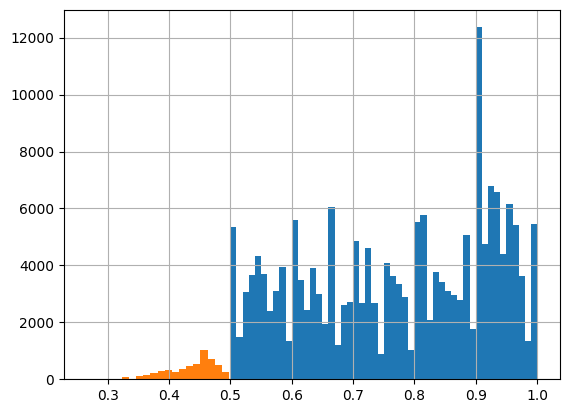

In [10]:
differ_sites[(differ_sites.cons_nuc.isin(list('ACGT')))][fcols].max(axis=1).hist(bins=50)
differ_sites[(~differ_sites.cons_nuc.isin(list('ACGT')))][fcols].max(axis=1).hist(bins=20)

### Get spectra

In [11]:
obs_poly = pd.read_csv("../data/chordata2/obs_muts_poly.csv")
obs_poly.rename(columns={'PosInGene': 'site'}, inplace=True)
obs_poly.head()

,Mut,Label,site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,seq_id,gene_species
0,C[A>G]T,0,25,1,ATT,GTT,I,V,0,ND1__Eleotris_fusca
1,C[G>A]G,2,645,3,TCG,TCA,S,S,0,ND1__Eleotris_fusca
2,T[A>G]C,1,876,3,ATA,ATG,M,M,0,ND1__Eleotris_fusca
3,T[T>C]C,2,57,3,GTT,GTC,V,V,1,ND1__Eleotris_fusca
4,C[C>T]G,2,564,3,GCC,GCT,A,A,1,ND1__Eleotris_fusca


In [12]:
# check that sites with max freq == 1 don't contain mutations
# there are few mutations in such sites due to strict freqs rounding 
a = differ_sites[differ_sites[fcols].max(axis=1).eq(1.)]
a["site"] += 1

a.merge(obs_poly, on=['gene_species', 'site']).groupby('gene_species').site.count().sort_values()#.assign(amb=True)

Series([], Name: site, dtype: int64)

In [13]:
bad_sites_df2520 = pd.read_csv('../data/chordata2/bad_sites.25.20.csv', 
                               usecols=['gene_species', 'site']).assign(amb=True)
bad_sites_df1510 = pd.read_csv('../data/chordata2/bad_sites.15.10.csv', 
                               usecols=['gene_species', 'site']).assign(amb=True)
bad_sites_df0505 = pd.read_csv('../data/chordata2/bad_sites.05.05.csv', 
                               usecols=['gene_species', 'site']).assign(amb=True)
differ_sites = pd.read_csv('../data/chordata2/sites_differ_between_cons_and_ingrp.csv').assign(amb=True)

bad_sites_df2520["site"] += 1
bad_sites_df1510["site"] += 1
bad_sites_df0505["site"] += 1
differ_sites["site"] += 1

In [14]:
bad_sites_df1510#.assign(amb=True)#["site"].min()|

,gene_species,site,amb
0,ND1__Anaxyrus_fowleri,24,True
1,ND1__Anaxyrus_fowleri,36,True
2,ND1__Anaxyrus_fowleri,69,True
3,ND1__Anaxyrus_fowleri,153,True
4,ND1__Anaxyrus_fowleri,162,True
...,...,...,...
334284,ND4L__Branchiostoma_belcheri,93,True
334285,ND4L__Branchiostoma_belcheri,102,True
334286,ND4L__Branchiostoma_belcheri,126,True
334287,ND4L__Branchiostoma_belcheri,159,True


In [15]:
obs_poly2520 = obs_poly.merge(bad_sites_df2520, 'left', ['gene_species', 'site'])
obs_poly1510 = obs_poly.merge(bad_sites_df1510, 'left', ['gene_species', 'site'])
obs_poly0505 = obs_poly.merge(bad_sites_df0505, 'left', ['gene_species', 'site'])
obs_poly_differ = obs_poly.merge(differ_sites, 'left', ['gene_species', 'site'])

obs_poly2520['amb'] = obs_poly2520['amb'].fillna(False)
obs_poly1510['amb'] = obs_poly1510['amb'].fillna(False)
obs_poly0505['amb'] = obs_poly0505['amb'].fillna(False)
obs_poly_differ['amb'] = obs_poly_differ['amb'].fillna(False)

In [16]:
obs_poly0505.head()

,Mut,Label,site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,seq_id,gene_species,amb
0,C[A>G]T,0,25,1,ATT,GTT,I,V,0,ND1__Eleotris_fusca,False
1,C[G>A]G,2,645,3,TCG,TCA,S,S,0,ND1__Eleotris_fusca,False
2,T[A>G]C,1,876,3,ATA,ATG,M,M,0,ND1__Eleotris_fusca,False
3,T[T>C]C,2,57,3,GTT,GTC,V,V,1,ND1__Eleotris_fusca,False
4,C[C>T]G,2,564,3,GCC,GCT,A,A,1,ND1__Eleotris_fusca,False


In [17]:
obs_poly2520.shape, obs_poly1510.shape, obs_poly0505.shape, obs_poly_differ.shape

((3782445, 11), (3782445, 11), (3782445, 11), (3782445, 17))

In [105]:
obs_poly2520.drop_duplicates(['gene_species', 'site']).amb.sum(), obs_poly1510.drop_duplicates(['gene_species', 'site']).amb.sum(), obs_poly0505.drop_duplicates(['gene_species', 'site']).amb.sum()

(178889, 290150, 531937)

In [334]:
bad_sites_df2520.shape, bad_sites_df1510.shape, bad_sites_df0505.shape, differ_sites.shape

((208254, 3), (334289, 3), (748202, 3), (194471, 9))

In [18]:
obs_poly_differ.amb.value_counts()

False    2600653
True     1181792
Name: amb, dtype: int64

In [19]:
obs_poly2520.amb.value_counts()

True     2081637
False    1700808
Name: amb, dtype: int64

In [20]:
obs_poly_freqs = complete_sbs192_columns(obs_poly[(obs_poly.Label > 0)].groupby(['gene_species'])\
    .Mut.value_counts().unstack().fillna(0.))
obs_poly2520freqs = complete_sbs192_columns(obs_poly2520[(~obs_poly2520.amb) & (obs_poly2520.Label > 0)].groupby(['gene_species'])\
    .Mut.value_counts().unstack().fillna(0.))
obs_poly1510freqs = complete_sbs192_columns(obs_poly1510[(~obs_poly1510.amb) & (obs_poly1510.Label > 0)].groupby(['gene_species'])\
    .Mut.value_counts().unstack().fillna(0.))
obs_poly0505freqs = complete_sbs192_columns(obs_poly0505[(~obs_poly0505.amb) & (obs_poly0505.Label > 0)].groupby(['gene_species'])\
    .Mut.value_counts().unstack().fillna(0.))

obs_poly_differ_freqs = complete_sbs192_columns(obs_poly_differ[(~obs_poly_differ.amb) & (obs_poly_differ.Label > 0)].groupby(['gene_species'])\
    .Mut.value_counts().unstack().fillna(0.))

In [21]:
obs_poly2520freqs

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
gene_species,,,,,,,,,,,,,,,,,,,,,
A6__Acanthurus_nigricans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Acanthurus_triostegus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Adelomyia_melanogenys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
A6__Agkistrodon_contortrix,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Agkistrodon_piscivorus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6__Vidua_purpurascens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ND6__Vireo_olivaceus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ND6__Vireo_solitarius,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

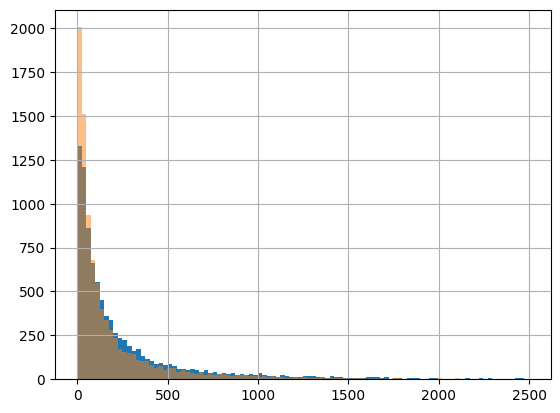

In [22]:
obs_poly_freqs.sum(axis=1)[obs_poly_freqs.sum(axis=1).lt(2500)].hist(bins=100)
obs_poly_differ_freqs.sum(axis=1)[obs_poly_differ_freqs.sum(axis=1).lt(2500)].hist(bins=100, alpha=0.5)

<AxesSubplot:>

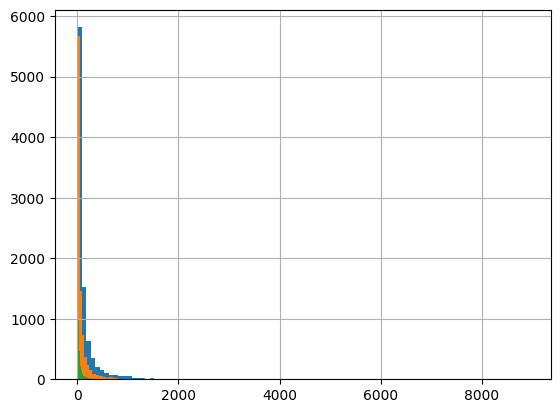

In [341]:
obs_poly2520freqs.sum(axis=1).hist(bins=100)
obs_poly1510freqs.sum(axis=1).hist(bins=100)
obs_poly0505freqs.sum(axis=1).hist(bins=100)

In [23]:
obs_poly_freqs12 = collapse_sbs192(obs_poly_freqs)[possible_sbs12]
obs_poly2520freqs12 = collapse_sbs192(obs_poly2520freqs)[possible_sbs12]
obs_poly1510freqs12 = collapse_sbs192(obs_poly1510freqs)[possible_sbs12]
obs_poly0505freqs12 = collapse_sbs192(obs_poly0505freqs)[possible_sbs12]
obs_poly_differ_freqs12 = collapse_sbs192(obs_poly_differ_freqs)[possible_sbs12]

In [24]:
obs_poly2520freqs12

Mut,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
gene_species,,,,,,,,,,,,
A6__Acanthurus_nigricans,0.0,10.0,0.0,1.0,0.0,8.0,2.0,0.0,1.0,0.0,6.0,0.0
A6__Acanthurus_triostegus,3.0,29.0,0.0,0.0,0.0,54.0,1.0,1.0,0.0,0.0,42.0,0.0
A6__Adelomyia_melanogenys,0.0,176.0,35.0,27.0,14.0,305.0,0.0,15.0,0.0,7.0,168.0,1.0
A6__Agkistrodon_contortrix,1.0,10.0,1.0,2.0,0.0,15.0,5.0,0.0,0.0,0.0,9.0,0.0
A6__Agkistrodon_piscivorus,0.0,7.0,0.0,0.0,0.0,7.0,10.0,0.0,0.0,0.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ND6__Vidua_purpurascens,0.0,3.0,0.0,0.0,0.0,6.0,2.0,0.0,4.0,0.0,6.0,0.0
ND6__Vireo_olivaceus,0.0,13.0,0.0,0.0,0.0,9.0,2.0,0.0,4.0,0.0,7.0,0.0
ND6__Vireo_solitarius,0.0,1.0,0.0,0.0,0.0,9.0,2.0,0.0,2.0,0.0,10.0,0.0


### Calc snp spectrum

In [25]:
exp = pd.read_csv('../data/chordata2/exp_num.csv', index_col=0)
exp.head()

,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
gene__species,,,,,,,,,,,,,,,,,,,,,
ND1__Eleotris_fusca,NaN,NaN,NaN,NaN,14.076923,8.461538,13.000000,6.769231,2.000000,NaN,...,82.230769,58.230769,58.230769,137.923077,24.307692,15.384615,15.384615,23.076923,61.461538,23.076923
ND1__Lasiurus_blossevillii,NaN,NaN,NaN,NaN,7.909091,9.636364,6.090909,10.272727,1.909091,NaN,...,72.090909,35.909091,35.909091,93.909091,22.727273,9.000000,9.000000,29.000000,93.181818,29.000000
ND1__Anaxyrus_fowleri,NaN,NaN,NaN,NaN,13.039216,8.490196,9.215686,5.568627,1.921569,3.901961,...,71.039216,44.098039,44.098039,79.411765,14.235294,7.176471,7.176471,40.823529,108.960784,40.823529
ND1__Lichanura_trivirgata,NaN,NaN,NaN,NaN,21.000000,10.600000,13.430769,17.323077,1.907692,3.953846,...,99.430769,41.215385,41.215385,114.953846,20.646154,11.000000,11.000000,12.261538,29.292308,12.261538
ND1__Anaxyrus_woodhousii,NaN,NaN,NaN,NaN,14.962264,10.660377,9.830189,5.754717,1.981132,3.905660,...,78.660377,41.000000,41.000000,82.698113,12.603774,6.471698,6.471698,42.792453,111.075472,42.792453


In [26]:
def calc_spectra(obs_freqs: pd.DataFrame, exp_freqs: pd.DataFrame):
    assert (obs_freqs.columns == exp_freqs.columns).all()
    ind = obs_freqs.index.intersection(exp_freqs.index)
    obs_freqs = obs_freqs.loc[ind]
    exp_freqs = exp_freqs.loc[ind]
    assert (obs_freqs.index == exp_freqs.index).all()

    sp = (obs_freqs / exp_freqs).replace(np.inf, 0.)
    sp = (sp.T / sp.sum(axis=1)).T.fillna(0.)
    return sp


In [27]:
spectra0000_12 = calc_spectra(obs_poly_freqs12, exp[possible_sbs12])
spectra2520_12 = calc_spectra(obs_poly2520freqs12, exp[possible_sbs12])
spectra1510_12 = calc_spectra(obs_poly1510freqs12, exp[possible_sbs12])
spectra0505_12 = calc_spectra(obs_poly0505freqs12, exp[possible_sbs12])
spectra_differ_12 = calc_spectra(obs_poly_differ_freqs12, exp[possible_sbs12])

spectra0000_192 = calc_spectra(obs_poly_freqs, exp[possible_sbs192])
spectra2520_192 = calc_spectra(obs_poly2520freqs, exp[possible_sbs192])
spectra1510_192 = calc_spectra(obs_poly1510freqs, exp[possible_sbs192])
spectra0505_192 = calc_spectra(obs_poly0505freqs, exp[possible_sbs192])
spectra_differ_192 = calc_spectra(obs_poly_differ_freqs, exp[possible_sbs192])

### Compare with main dataset

In [28]:
obs12 = pd.read_csv('../data/chordata2/obs_num12.csv', index_col=0).fillna(0.)
obs192 = pd.read_csv('../data/chordata2/obs_num192.csv', index_col=0).fillna(0.)
spectra12 = pd.read_csv('../data/chordata2/spectra12.csv', index_col=0).fillna(0.)
spectra192 = pd.read_csv('../data/chordata2/spectra192.csv', index_col=0).fillna(0.)
obs192.head()

,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
gene__species,,,,,,,,,,,,,,,,,,,,,
A6__Acanthurus_triostegus,0.0,0.0,0.0,0.0,0.00000,0.973268,0.0,0.99938,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Adelomyia_melanogenys,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
A6__Agkistrodon_contortrix,0.0,0.0,0.0,0.0,0.99947,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Agkistrodon_piscivorus,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Alethe_diademata,0.0,0.0,0.0,0.0,0.00000,1.142050,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
for df_snp, lbl in zip(
    [spectra0000_12, spectra2520_12, spectra1510_12, spectra0505_12, spectra_differ_12],
    ['spectra0000_12', 'spectra2520_12', 'spectra1510_12', 'spectra0505_12', 'spectra_differ_12']
):
    cossim = get_cossim(spectra12, df_snp)
    print(lbl)
    print(f'size: {cossim.shape[0]}\nmedian: {cossim.median():.2f}\nmean: {cossim.mean():.2f}, std: {cossim.std():.2f}\n')

spectra0000_12
size: 8815
median: 0.97
mean: 0.92, std: 0.12

spectra2520_12
size: 8812
median: 0.95
mean: 0.88, std: 0.16

spectra1510_12
size: 8800
median: 0.92
mean: 0.83, std: 0.21

spectra0505_12
size: 4039
median: 0.86
mean: 0.76, std: 0.25

spectra_differ_12
size: 8815
median: 0.96
mean: 0.90, std: 0.15



<AxesSubplot:>

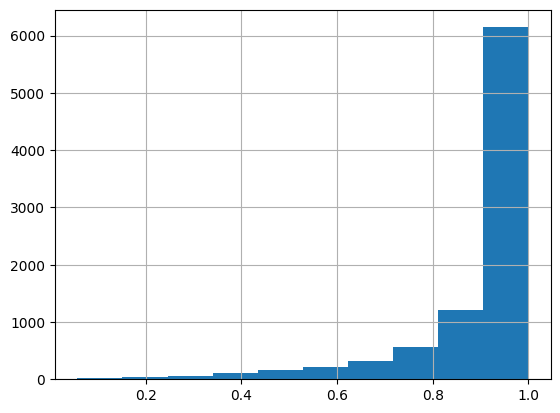

In [30]:
get_cossim(spectra12, spectra_differ_12).hist()

In [31]:
for df_snp, lbl in zip(
    [spectra0000_192, spectra2520_192, spectra1510_192, spectra0505_192, spectra_differ_192],
    ['spectra0000_192', 'spectra2520_192', 'spectra1510_192', 'spectra0505_192', 'spectra_differ_192']
):
    cossim = get_cossim(spectra192, df_snp)
    print(lbl)
    print(f'size: {cossim.shape[0]}\nmedian: {cossim.median():.2f}\nmean: {cossim.mean():.2f}, std: {cossim.std():.2f}\n')

spectra0000_192
size: 7017
median: 0.73
mean: 0.70, std: 0.16

spectra2520_192
size: 7017
median: 0.68
mean: 0.66, std: 0.17

spectra1510_192
size: 7013
median: 0.62
mean: 0.61, std: 0.20

spectra0505_192
size: 3807
median: 0.49
mean: 0.51, std: 0.21

spectra_differ_192
size: 7017
median: 0.75
mean: 0.72, std: 0.16



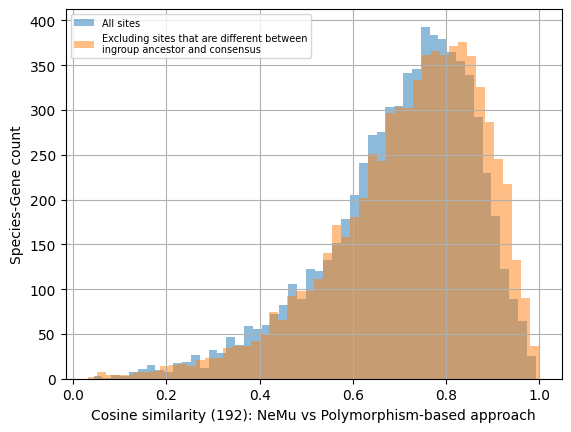

In [163]:
get_cossim(spectra192, spectra0000_192).hist(bins=50, alpha=0.5, label='All sites')
get_cossim(spectra192, spectra_differ_192).hist(bins=50, alpha=0.5, label='Excluding sites that are different between\ningroup ancestor and consensus')
plt.legend(fontsize=7)
plt.xlabel('Cosine similarity (192): NeMu vs Polymorphism-based approach')
plt.ylabel('Species-Gene count')
plt.savefig('../figures/compare_spectra_with_polymorphs.pdf')
plt.show()

### cossim vs #mut and #seq

In [33]:
cossim12 = get_cossim(spectra12, spectra0000_12).rename('cossim12').to_frame()
cossim192 = get_cossim(spectra192, spectra0000_192).rename('cossim192').to_frame()

In [34]:
nseqs = pd.read_csv('../data/chordata2/nseqs.csv', index_col=0)

nobs = obs_poly[obs_poly.Label > 0].groupby('gene_species').Mut.count().rename('nobs').to_frame()

In [35]:
df12  = cossim12.merge( nobs, left_index=True, right_index=True).merge(nseqs, left_index=True, right_index=True)
df192 = cossim192.merge(nobs, left_index=True, right_index=True).merge(nseqs, left_index=True, right_index=True)

#### cossim vs nobs

spectra0000_192
size: 7017
median: 0.73
mean: 0.70, std: 0.16


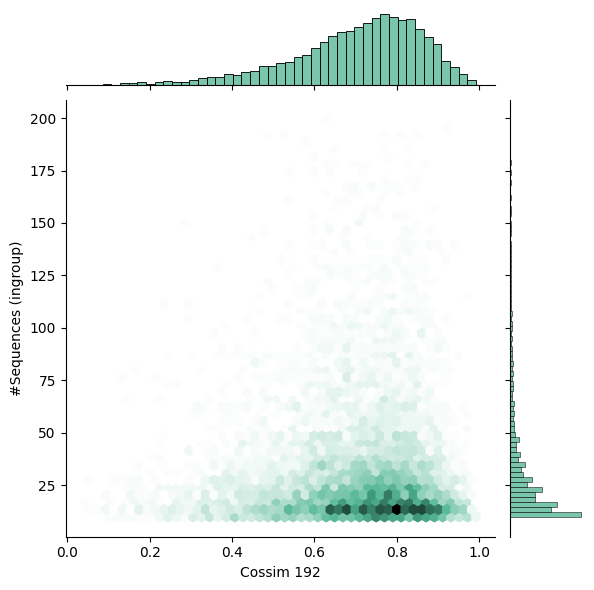

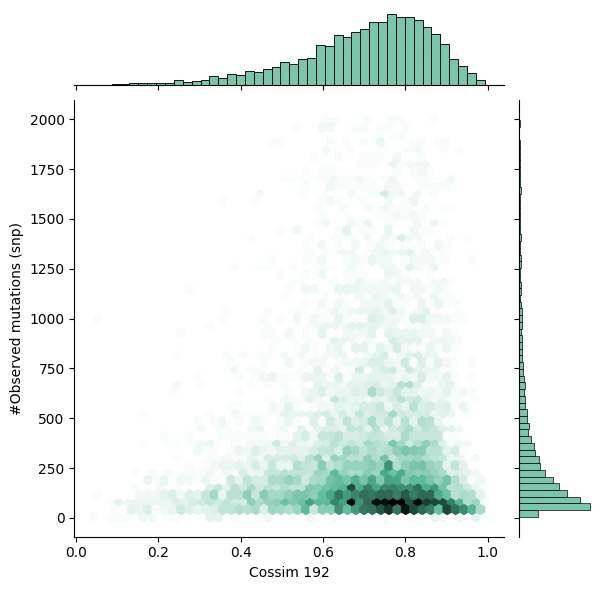

spectra2520_192
size: 7017
median: 0.68
mean: 0.66, std: 0.17


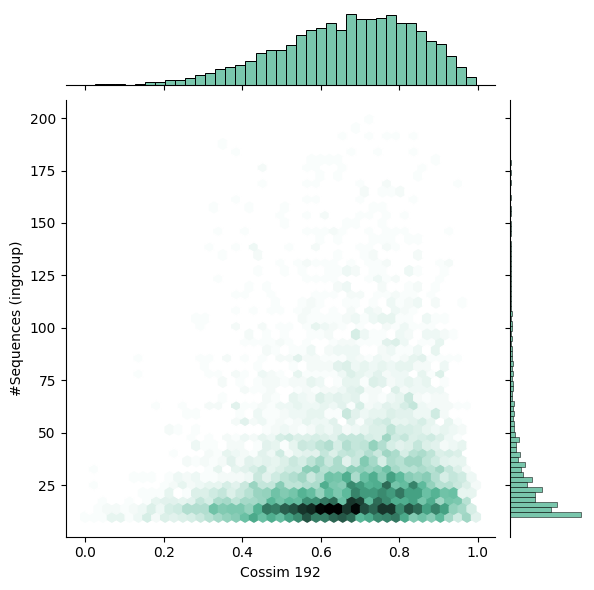

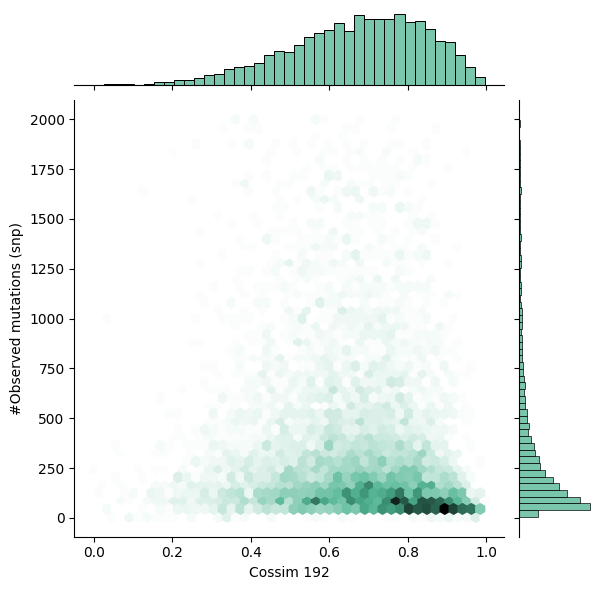

spectra1510_192
size: 7013
median: 0.62
mean: 0.61, std: 0.20


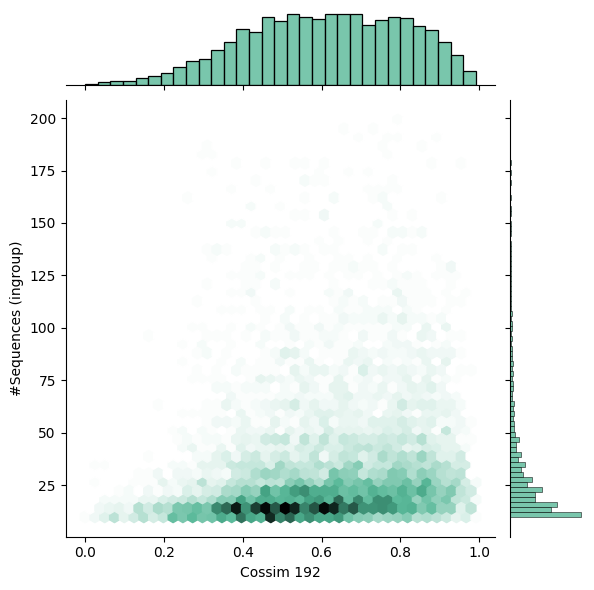

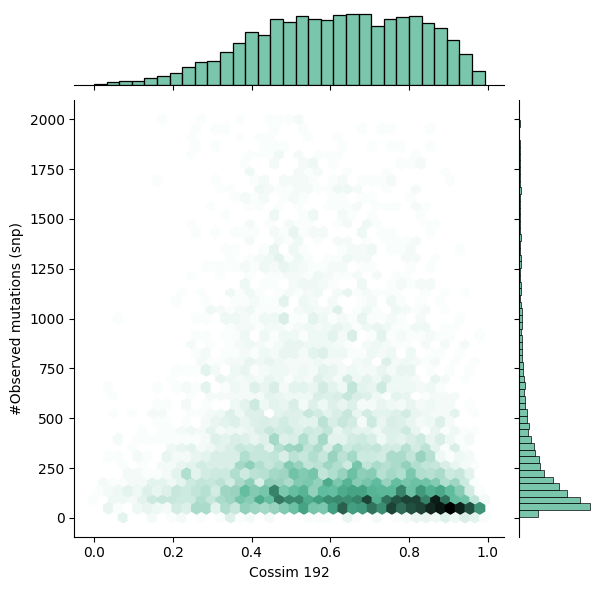

spectra0505_192
size: 3807
median: 0.49
mean: 0.51, std: 0.21


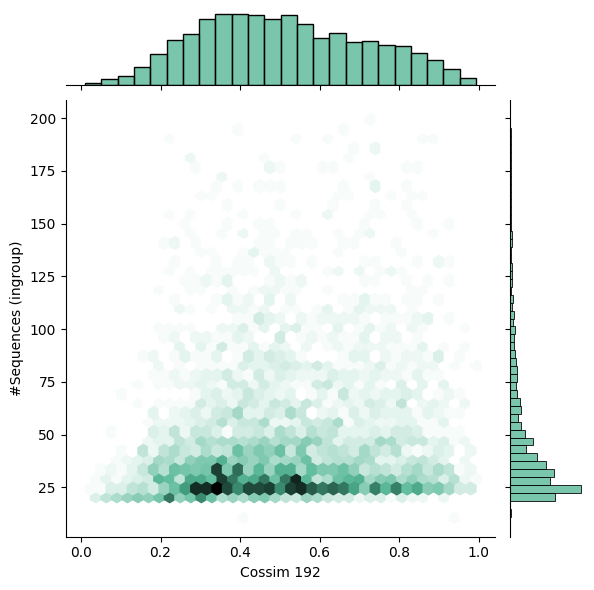

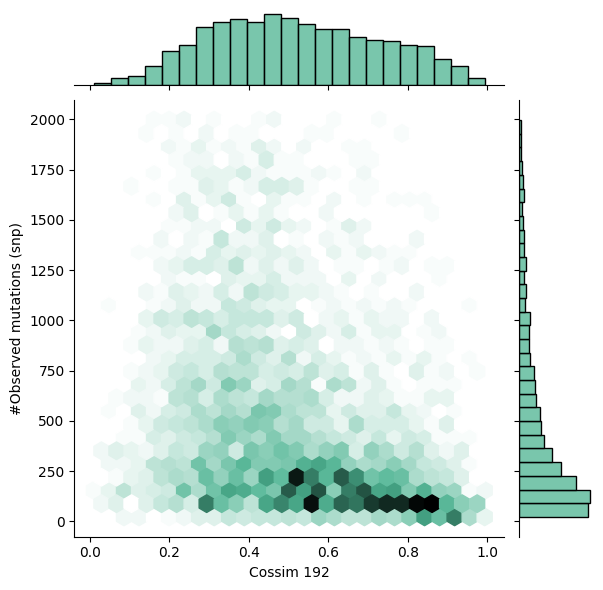

In [213]:
for df_snp, lbl in zip(
    [spectra0000_192, spectra2520_192, spectra1510_192, spectra0505_192],
    ['spectra0000_192', 'spectra2520_192', 'spectra1510_192', 'spectra0505_192']
):
    cossim = get_cossim(spectra192, df_snp)
    print(lbl)
    print(f'size: {cossim.shape[0]}\nmedian: {cossim.median():.2f}\nmean: {cossim.mean():.2f}, std: {cossim.std():.2f}')

    df192 = cossim.rename('cossim192').to_frame()\
        .merge(nobs, left_index=True, right_index=True).merge(nseqs, left_index=True, right_index=True)

    g = sns.jointplot(
        data=df192[df192.nseqs < 200],
        x="cossim192", y="nseqs", #hue="species",
        kind="hex", color="#4CB391"
    ).set_axis_labels("Cossim 192", "#Sequences (ingroup)");

    g = sns.jointplot(
        data=df192[df192.nobs < 2000],
        x="cossim192", y="nobs", #hue="species",
        kind="hex", color="#4CB391"
    ).set_axis_labels("Cossim 192", "#Observed mutations (snp)");
    plt.show()

### Calculate distance with star-like trees

In [36]:
import ete3
from ete3 import PhyloTree
from pymutspec.annotation.tree import iter_tree_edges

In [5]:
paths_tree = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/*/*/final_tree.nwk') 
len(paths_tree)

9238

In [37]:
def get_ingroup_tree(t: PhyloTree, outgrp='OUTGRP'):
    for n in t.children:
        if n.name == outgrp:
            continue
        else:
            n = n.copy()
            n.dist = 0.
            return n


def get_star_like_tree(t: PhyloTree):
    star_like = PhyloTree(name=t.name, dist=t.dist)
    for l in t.iter_leaves():
        d = t.get_distance(l)
        star_like.add_child(name=l.name, dist=d)
    # star_like.set_outgroup('OUTGRP')
    return star_like


def get_sum_of_edges(t: PhyloTree):
    d = 0.
    for x in t.iter_descendants():
        d += x.dist
    return d


def compare_with_starlike(t: PhyloTree):
    it = get_ingroup_tree(t)
    star_like = get_star_like_tree(it)
    it_l = get_sum_of_edges(it)
    star_like_l = get_sum_of_edges(star_like)    
    d = star_like_l - it_l
    return d, d / star_like_l

#### Test star like

In [ ]:
t = PhyloTree(paths_tree[1], format=1)

In [ ]:
t.describe()
print(t.get_ascii(True, False, ['name', 'dist']))

Number of leaf nodes:	12
Total number of nodes:	23
Rooted:	Yes
Most distant node:	RN_4
Max. distance:	0.204732

         /-OUTGRP, 0.0684376
        |
        |                                                                         /-RN_5, 0.0031626407
        |                                                      /Node4, 0.0053114579
        |                                                     |                   \-RN_11, 0.0074433136
-ROOT, 0.0                                  /Node3, 0.0021123394
        |                                  |                  |                  /-RN_9, 0.0041894463
        |                /Node2, 0.1099849955                  \Node5, 0.001002757
        |               |                  |                                     \-RN_8, 0.0010277353
        |               |                  |
        |               |                   \-RN_10, 4.6471e-06
         \Node1, 0.0684376
                        |                                      /-RN_7,

In [31]:
it = get_ingroup_tree(t)
it.describe()
print(it.get_ascii(True, False, ['name', 'dist']))

Number of leaf nodes:	11
Total number of nodes:	21
Rooted:	Yes
Most distant node:	RN_4
Max. distance:	0.136295

                                                                   /-RN_5, 0.0031626407
                                                /Node4, 0.0053114579
                                               |                   \-RN_11, 0.0074433136
                             /Node3, 0.0021123394
                            |                  |                  /-RN_9, 0.0041894463
          /Node2, 0.1099849955                  \Node5, 0.001002757
         |                  |                                     \-RN_8, 0.0010277353
         |                  |
         |                   \-RN_10, 4.6471e-06
-Node1, 0.0
         |                                      /-RN_7, 0.003195907
         |                   /Node7, 0.0029828369
         |                  |                   \-RN_6, 0.0010275464
         |                  |
          \Node6, 0.1021648818            

In [32]:
star_like = get_star_like_tree(it)
star_like.describe()
print(star_like.get_ascii(True, False, ['name', 'dist']))

Number of leaf nodes:	11
Total number of nodes:	12
Rooted:	No
Most distant node:	RN_4
Max. distance:	0.136295

          /-RN_5, 0.1205714335
         |
         |--RN_11, 0.1248521064
         |
         |--RN_9, 0.1172895382
         |
         |--RN_8, 0.1141278272
         |
         |--RN_10, 0.1099896426
         |
-Node1, 0.0-RN_7, 0.1083436257
         |
         |--RN_6, 0.1061752651
         |
         |--RN_4, 0.1362948275
         |
         |--RN_3, 0.1342842206
         |
         |--RN_2, 0.1330243256
         |
          \-RN_1, 0.133022666


#### Get Star like difference

In [133]:
diffs = []
for path_fasta in tqdm.tqdm(paths_tree):
    p_elements = path_fasta.split('/')
    gene_species = p_elements[8]

    t = PhyloTree(path_fasta, format=1)
    d, d_scaled = compare_with_starlike(t)
    diffs.append([gene_species, d, d_scaled])

diffs_df = pd.DataFrame(diffs, columns=['gene_species', 'star_like_d', 'star_like_d_scaled'])

100%|██████████| 9238/9238 [00:39<00:00, 231.39it/s]


In [378]:
# max distances in the dataset
diffs_df.sort_values('star_like_d').tail(20)

,gene_species,star_like_d,star_like_d_scaled
1218,ND2__Anolis_distichus,54.893102,0.965237
1572,ND2__Gehyra_nana,57.447843,0.922309
3165,CO1__Molgula_manhattensis,58.544323,0.908800
5086,Cytb__Eremias_velox,61.718633,0.981949
2629,CO1__Ascidia_ceratodes,62.596796,0.917604
1539,ND2__Anolis_cybotes,71.762497,0.952881
6806,A8__Sus_scrofa,74.851122,0.943151
2682,CO1__Asterocarpa_humilis,75.129348,0.823698
5226,Cytb__Branchiostoma_belcheri,79.276539,0.856699
7814,ND4__Branchiostoma_belcheri,94.823649,0.915379


In [380]:
diffs_df[['star_like_d', 'star_like_d_scaled']].describe()

,star_like_d,star_like_d_scaled
count,9238.000000,9238.000000
mean,1.919253,0.693215
std,37.393410,0.246682
min,0.000021,0.000005
25%,0.092358,0.643504
50%,0.317142,0.764643
75%,1.077206,0.850592
max,3505.523678,0.993625


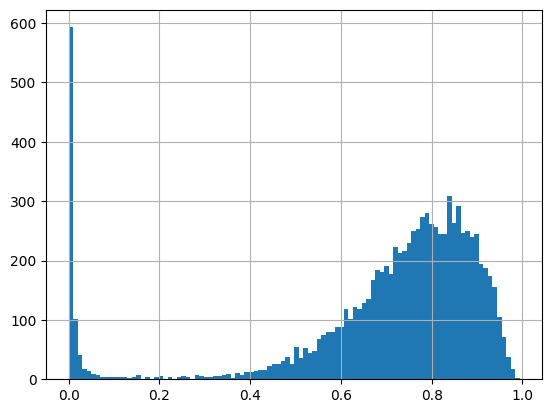

In [137]:
diffs_df.star_like_d_scaled.hist(bins=100);

In [138]:
diffs_df.to_csv('../data/chordata2/star_like_d.csv', index=False)

In [38]:
diffs_df = pd.read_csv('../data/chordata2/star_like_d.csv', index_col=0)

spectra_differ_192
size: 7017
median: 0.75
mean: 0.72, std: 0.16


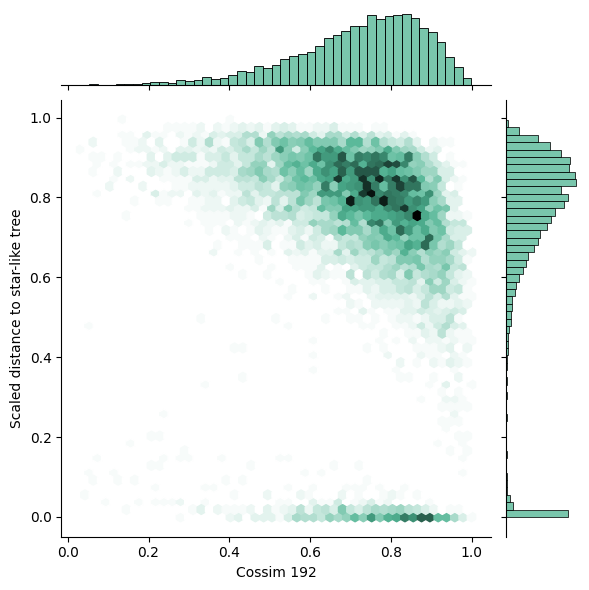

In [49]:
cossim = get_cossim(spectra192, spectra_differ_192)
print(lbl)
print(f'size: {cossim.shape[0]}\nmedian: {cossim.median():.2f}\nmean: {cossim.mean():.2f}, std: {cossim.std():.2f}')
df192 = cossim.rename('cossim192').to_frame()\
    .merge(diffs_df, left_index=True, right_index=True)

g = sns.jointplot(
    data=df192, x="cossim192", y="star_like_d_scaled", #hue="species",
    kind="hex", color="#4CB391"
).set_axis_labels("Cossim 192", "Scaled distance to star-like tree");

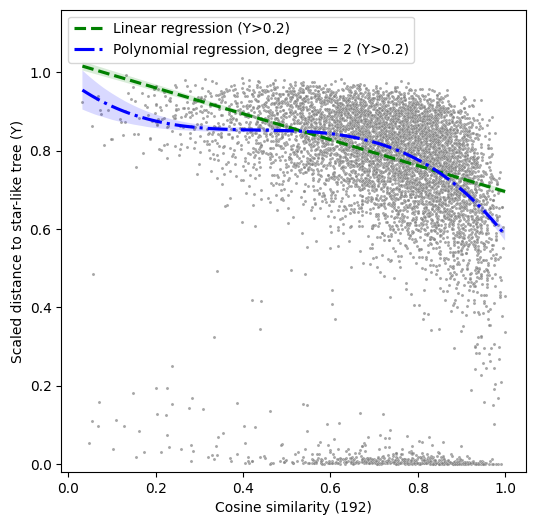

In [161]:
plt.figure(figsize=(6, 6))

ax = sns.scatterplot(
    data=df192, x="cossim192", y="star_like_d_scaled",
    **{'color':'gray', 's': 5, 'alpha':.7}, #label='data',
)

_d = df192[df192.star_like_d_scaled > 0.2].sort_values('cossim192')
ax = sns.regplot(
    data=_d, x="cossim192", y="star_like_d_scaled",
    line_kws={'color':'green', 'linestyle':'--'}, scatter=False,
    ax=ax, label='Linear regression (Y>0.2)', 
    x_ci=95,
)
ax = sns.regplot(
    data=_d, x="cossim192", y="star_like_d_scaled",
    line_kws={'color':'blue', 'linestyle':'-.'}, scatter=False,
    ax=ax, label='Polynomial regression, degree = 2 (Y>0.2)', 
    order=3, x_ci=95,
)

# x = _d.cossim192.values
# y = _d.star_like_d_scaled.values

# tck = splrep(x, y, s=70)
# plt.plot(x, BSpline(*tck)(x), 'r-', label='Smoothed line (Y>0.2)')


ax.set_ylim(-0.02, 1.16)
ax.set_xlabel("Cosine similarity (192)")
ax.set_ylabel("Scaled distance to star-like tree (Y)")
plt.legend(loc='upper left')
plt.savefig('../figures/cossim_vs_star_like_d.pdf')
plt.show()

In [51]:
df192.to_csv('../data/chordata2/cossim192_vs_star_like_d.csv', index=False)

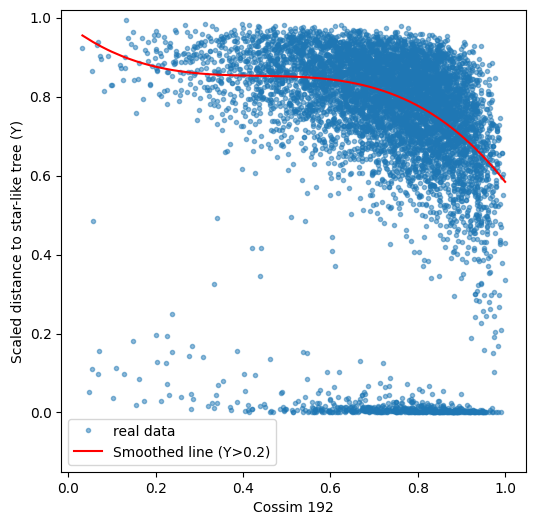

In [81]:
from scipy.interpolate import splrep, BSpline

# x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/16)
# rng = np.random.default_rng()
# y = np.sin(x) + 0.4*rng.standard_normal(size=len(x))

_d = df192[df192.star_like_d_scaled > 0.2].sort_values('cossim192')
x = _d.cossim192.values
y = _d.star_like_d_scaled.values

s = 70
tck = splrep(x, y, s=s)
# tck_s = splrep(x, y, s=10)

# xnew = np.arange(0, 9/4, 1/50) * np.pi
# plt.plot(xnew, np.sin(xnew), '-.', label='sin(x)')

plt.figure(figsize=(6, 6))
plt.plot(df192.cossim192.values, df192.star_like_d_scaled.values, 
         '.', alpha=0.5, label='real data')
plt.plot(x, BSpline(*tck)(x), 'r-', label='Smoothed line (Y>0.2)')
# plt.plot(x, BSpline(*tck_s)(x), '-', label=f's=10')
plt.xlabel("Cossim 192")
plt.ylabel("Scaled distance to star-like tree (Y)")
plt.legend(loc='lower left')
plt.ylim(-0.15, 1.02)
plt.show()

In [390]:
nseqs = pd.read_csv('../data/chordata2/nseqs.csv', index_col=0)
nobs = obs_poly_differ[obs_poly_differ.Label > 0].groupby('gene_species').Mut.count().rename('nobs').to_frame()


all_metrics = df192.merge(nseqs, right_index=True, left_index=True).merge(nobs, right_index=True, left_index=True)

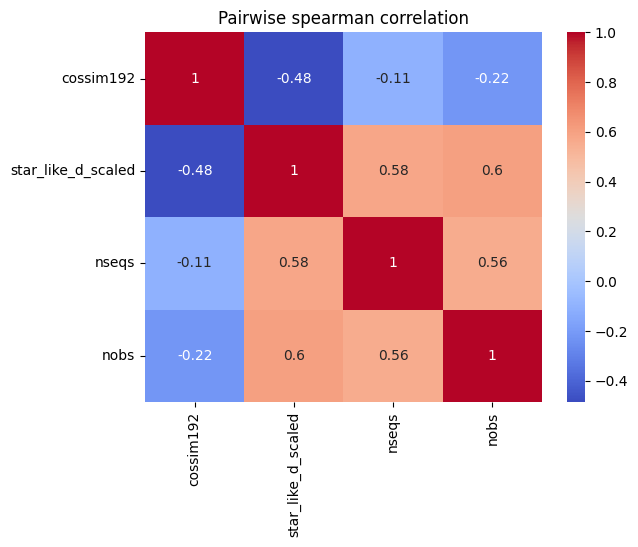

In [400]:
sns.heatmap(all_metrics[all_metrics.star_like_d_scaled > 0.2].drop('star_like_d', axis=1)\
    .corr('spearman'), cmap="coolwarm", annot=True)\
        .set_title('Pairwise spearman correlation');

In [391]:
all_metrics[all_metrics.star_like_d_scaled > 0.2].corr('spearman')

,cossim192,star_like_d,star_like_d_scaled,nseqs,nobs
cossim192,1.000000,-0.394974,-0.484878,-0.105965,-0.223516
star_like_d,-0.394974,1.000000,0.773675,0.494063,0.825438
star_like_d_scaled,-0.484878,0.773675,1.000000,0.579852,0.600350
nseqs,-0.105965,0.494063,0.579852,1.000000,0.556394
nobs,-0.223516,0.825438,0.600350,0.556394,1.000000


In [446]:
from scipy.stats import spearmanr

# Example data
x = all_metrics[all_metrics.star_like_d_scaled > 0.2].cossim192
y = all_metrics[all_metrics.star_like_d_scaled > 0.2].star_like_d_scaled

# Calculate Spearman correlation
correlation, p_value = spearmanr(x, y)

print(f"Spearman correlation coefficient: {correlation:.2f}")
print("p-value:", p_value)

Spearman correlation coefficient: -0.48
p-value: 0.0


In [439]:
all_metrics[all_metrics.star_like_d_scaled > 0.2].cossim192

,cossim192,star_like_d,star_like_d_scaled,nseqs,nobs
A6__Acanthurus_triostegus,0.399370,1.124099,0.901997,59,382
A6__Adelomyia_melanogenys,0.728215,3.799916,0.883849,82,1638
A6__Agkistrodon_contortrix,0.340319,0.651324,0.818617,28,173
A6__Agkistrodon_piscivorus,0.381977,0.696662,0.895862,20,162
A6__Alethe_diademata,0.779722,4.263540,0.908976,31,390
...,...,...,...,...,...
ND6__Ursus_americanus,0.244180,1.771693,0.890721,18,125
ND6__Ursus_arctos,0.653236,1.191989,0.831384,82,306
ND6__Ursus_thibetanus,0.785251,0.100669,0.433588,11,56
ND6__Vireo_olivaceus,0.928091,0.132726,0.623768,30,62
